In [28]:
import sys
sys.path.append('../')
from model.unet import UNet2D
import m8r
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utils.Read_SEGY import ReadSEGYData
plt.style.use('default')

In [29]:
nt = 1126
nr = 350

dt = 0.008
dr = 0.02286

In [30]:
path = '../dataset/Pluto_shot30.sgy'
data = ReadSEGYData(path)
data.shape

     Number of Trace   = 350
     Number of Samples = 1126
     Start Samples     = 0
     Sampling Rate     = 8000


(1126, 350)

In [31]:
def mutter(input, x0, t0, k1, k2, delta):
    input = input
    n1, n2 = input.shape
    
    for i in range(n1):
        for j in range(n2):
            # Apply conditions for j < x0 (left side)
            if j < x0:
                if i - delta < np.floor(-k1 * j + t0 + k1 * x0):
                    input[i, j] = 0
            # Apply conditions for j >= x0 (right side)
            if j >= x0:
                if i - delta < np.floor(k2 * j + t0 - k2 * x0):
                    input[i, j] = 0
    
    return input

In [32]:
input = data.copy()
image = mutter(input, 0, 50, 1, 1.8, 10)

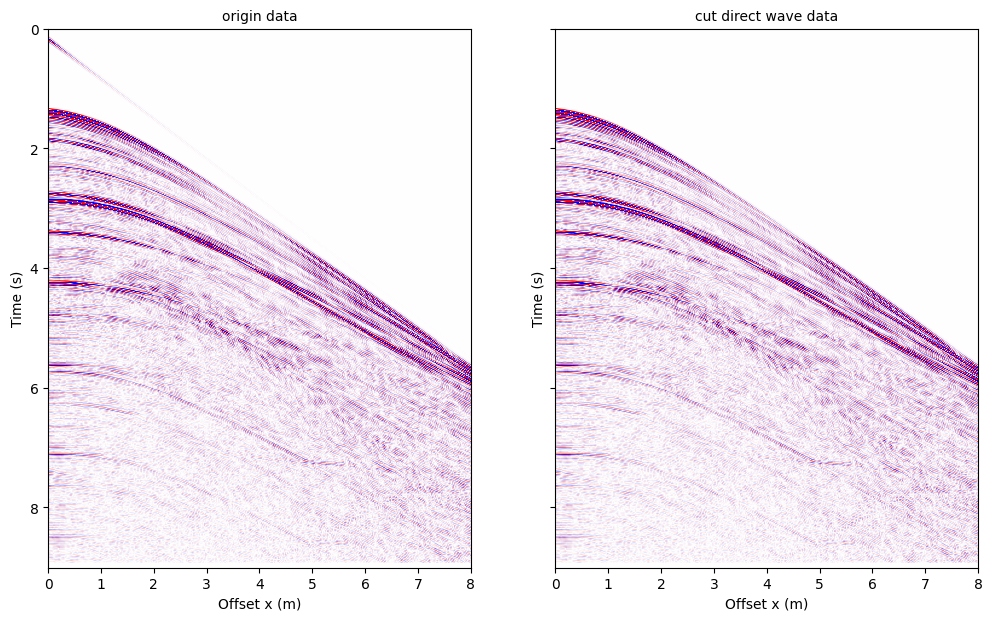

In [33]:
vmax = 1e-3
vmin = -vmax

fig, axs = plt.subplots(1, 2, figsize=(12, 7),sharey=True)

axs[0].imshow(data, aspect='auto', vmin=vmin, vmax=vmax,
              extent=(0, nr*dr, nt*dt, 0),cmap='bwr_r')
axs[0].set_title('origin data',fontsize=10)
axs[0].set_xlabel('Offset x (m)',fontsize=10)
axs[0].set_ylabel('Time (s)',fontsize=10)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

axs[1].imshow(image, aspect='auto', vmin=vmin, vmax=vmax,
              extent=(0, nr*dr, nt*dt, 0),cmap='bwr_r')
axs[1].set_title('cut direct wave data',fontsize=10)
axs[1].set_xlabel('Offset x (m)',fontsize=10)
axs[1].set_ylabel('Time (s)',fontsize=10)
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

In [34]:
mean = np.mean(image)
std = np.std(image)
image =  (image - mean) / std

In [35]:
input = torch.from_numpy(image)
input.unsqueeze_(0)
input.unsqueeze_(0)
input.shape

torch.Size([1, 1, 1126, 350])

In [36]:
net = UNet2D(1, 1)


weight = '../checkpoint/model_epoch_100.pth'
checkpoint = torch.load(weight)
net.load_state_dict(checkpoint["model_state_dict"])

net.eval()

UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [37]:
output = net(input)
output = output.squeeze().detach().numpy()
output.shape

(1126, 350)

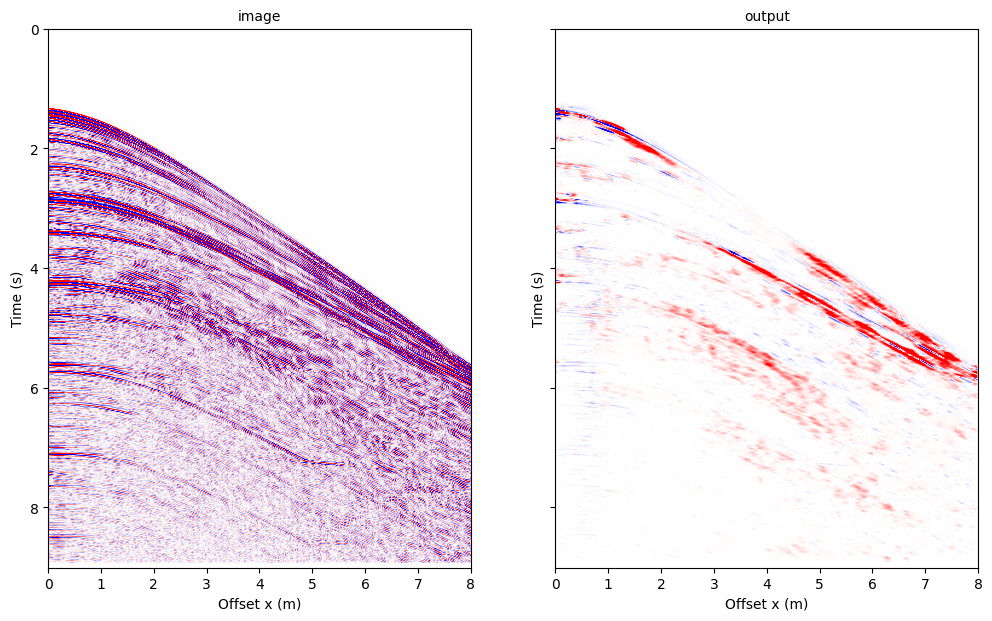

In [39]:
vmax = 1e0
vmin = -vmax

fig, axs = plt.subplots(1, 2, figsize=(12, 7),sharey=True)

axs[0].imshow(image, aspect='auto', vmin=vmin, vmax=vmax,
              extent=(0, nr*dr, nt*dt, 0),cmap='bwr_r')
axs[0].set_title('image',fontsize=10)
axs[0].set_xlabel('Offset x (m)',fontsize=10)
axs[0].set_ylabel('Time (s)',fontsize=10)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

axs[1].imshow(output, aspect='auto', vmin=vmin, vmax=vmax,
              extent=(0, nr*dr, nt*dt, 0),cmap='bwr_r')
axs[1].set_title('output',fontsize=10)
axs[1].set_xlabel('Offset x (m)',fontsize=10)
axs[1].set_ylabel('Time (s)',fontsize=10)
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)